## **IMPORT DATA**

In [ ]:
import pandas as pd

DATA_PATH = '/content/train1.csv'
data = pd.read_csv(DATA_PATH)

data.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


## **DATA PREPOCESSING**

In [ ]:
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

X = data['headline'].values.tolist()
y = data['clickbait'].values

X_xl = data['headline'].values
y_xl = data['clickbait'].values

def remove_punctuation(text):
  removedpunctuation = "".join([i for i in text if i not in string.punctuation])
  return removedpunctuation

tokenizer = RegexpTokenizer(r'\w+')

def tokenization(text):
    tokens = tokenizer.tokenize(text)
    return tokens

stopwords = stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

X = map(lambda x: remove_punctuation(x),X)
X = map(lambda x: x.lower(), X)
X = map(lambda x: tokenization(x), X)
X = map(lambda x: remove_stopwords(x), X)
X = map(lambda x: lemmatizer(x), X)
X = map(lambda x: " ".join(x), X)
X = np.array(list(X))

print(X)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


['get bings' 'tv female friend group belong'
 'new star war force awakens trailer give chill' ...
 'drone smartphone app help heart attack victim remote area announced'
 'netanyahu urge pope benedict israel denounce iran'
 'computer maker prepare stake bigger claim phone']


## **TRAIN TEST SPLIT**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_trainVal, y_train, y_trainVal = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)
X_test, X_testVal, y_test, y_testVal = train_test_split(X_trainVal , y_trainVal, test_size=0.5, random_state=0, stratify= y_trainVal)

X_train_xl, X_trainVal_xl, y_train_xl, y_trainVal_xl = train_test_split(X_xl, y_xl, test_size=0.2, random_state=0, stratify= y_xl)
X_test_xl, X_testVal_xl, y_test_xl, y_testVal_xl = train_test_split(X_trainVal_xl, y_trainVal_xl, test_size=0.5, random_state=0, stratify=y_trainVal_xl)

## **BILSTM MODEL**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, TextVectorization, Embedding, Input, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow import squeeze
import tensorflow as tf

text_vectorization = TextVectorization(
  max_tokens=5000,
  output_mode='int',
  output_sequence_length=500
)

text_vectorization.adapt(X_train)

input_lstm = Input(shape=(1,), dtype=tf.string)
embedding = Embedding(5001, 32, input_length=500)(text_vectorization(input_lstm))
lstm = Bidirectional(LSTM(32, return_sequences=True))(embedding)
pooling = GlobalMaxPooling1D()(lstm)
dropout = Dropout(0.2)(pooling)
output = Dense(1, activation='sigmoid')(dropout)
model = Model(inputs=[input_lstm], outputs=[output])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 32)           160032    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          16640     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                             

## **XLNET MODEL**

In [ ]:
!pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00


In [ ]:
from transformers import XLNetTokenizer, TFXLNetModel

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

def tokenize(data):
    id = []
    for x in data:
        tokenized = tokenizer.encode_plus(
            x,
            add_special_tokens=True,
            max_length=128,
            padding='max_length'
        )
        id.append(tokenized['input_ids'])
    return np.array(id)

X_train_xl = tokenize(X_train_xl)
X_test_xl = tokenize(X_test_xl)
X_testVal_xl = tokenize(X_testVal_xl)

word_inputs = Input(shape=(128,), name='word_inputs', dtype='int32')

xlnet = TFXLNetModel.from_pretrained('xlnet-base-cased')
xlnet_encodings = xlnet(word_inputs)[0]

doc_encoding = squeeze(xlnet_encodings[:, -1:, :], axis=1)

doc_encoding = Dropout(.1)(doc_encoding)

outputs = Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

xlnetmodel = Model(inputs=[word_inputs], outputs=[outputs])

xlnetmodel.summary()

xlnetmodel.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=2e-5), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel w

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 128)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 128,            
                              768),                              
                              mems=((128, None, 768),            
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),                  
                              (128, None, 768),            

## **MODEL TRAINING**

In [ ]:
epochs = 10
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_testVal, y_testVal), epochs=epochs)

Epoch 1/10
50/50 [==============================] - 25s 280ms/step - loss: 0.6490 - accuracy: 0.7902 - val_loss: 0.4905 - val_accuracy: 0.9075
Epoch 2/10
50/50 [==============================] - 8s 157ms/step - loss: 0.2502 - accuracy: 0.9358 - val_loss: 0.1719 - val_accuracy: 0.9538
Epoch 3/10
50/50 [==============================] - 6s 119ms/step - loss: 0.1519 - accuracy: 0.9598 - val_loss: 0.1514 - val_accuracy: 0.9569
Epoch 4/10
50/50 [==============================] - 5s 104ms/step - loss: 0.1126 - accuracy: 0.9700 - val_loss: 0.1423 - val_accuracy: 0.9581
Epoch 5/10
50/50 [==============================] - 4s 88ms/step - loss: 0.0922 - accuracy: 0.9747 - val_loss: 0.1336 - val_accuracy: 0.9581
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0775 - accuracy: 0.9772 - val_loss: 0.1373 - val_accuracy: 0.9553
Epoch 7/10
50/50 [==============================] - 4s 71ms/step - loss: 0.0674 - accuracy: 0.9786 - val_loss: 0.1251 - val_accuracy: 0.9584
Epoch 8/

In [ ]:
epochs_xl = 5
history_xl = xlnetmodel.fit(X_train_xl, y_train_xl, validation_data=(X_testVal_xl, y_testVal_xl), epochs=epochs_xl, batch_size=64)

Epoch 1/5


400/400 [==============================] - 904s 2s/step - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.0185 - val_accuracy: 0.9944
Epoch 2/5
400/400 [==============================] - 862s 2s/step - loss: 0.0222 - accuracy: 0.9926 - val_loss: 0.0094 - val_accuracy: 0.9969
Epoch 3/5
400/400 [==============================] - 859s 2s/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0158 - val_accuracy: 0.9956
Epoch 4/5
400/400 [==============================] - 855s 2s/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0067 - val_accuracy: 0.9975
Epoch 5/5
400/400 [==============================] - 858s 2s/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0095 - val_accuracy: 0.9978


## **PARAMATER COMPARISON**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

test_results = model.evaluate(X_test, y_test)
print("The model test accuracy is {}.".format(test_results[1]))
test_predictions = model.predict(X_test)

test_predictions = np.array([round(i[0]) for i in test_predictions])

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(y_test)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(y_test, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(y_test, test_predictions))

100/100 [==============================] - 1s 14ms/step - loss: 0.2085 - accuracy: 0.9509
The model test accuracy is 0.9509375095367432.
100/100 [==============================] - 2s 13ms/step

Predicted Class:
[1 0 1 ... 1 1 0]

Ground Truth:
[1 0 1 ... 0 1 0]


Confusion Matrix:
[[1524   76]
 [  81 1519]]


Accuracy: 0.9509375
F1 Score:  0.9509373802182134


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1600
           1       0.95      0.95      0.95      1600

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



In [ ]:
test_results = xlnetmodel.evaluate(X_test_xl, y_test_xl)
print("The model test accuracy is {}.".format(test_results[1]))
test_predictions = xlnetmodel.predict(X_test_xl)

test_predictions = np.array([round(i[0]) for i in test_predictions])

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(y_test_xl)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test_xl, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(y_test_xl, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(y_test_xl, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(y_test_xl, test_predictions))

100/100 [==============================] - 39s 357ms/step - loss: 0.0262 - accuracy: 0.9966
The model test accuracy is 0.9965624809265137.
100/100 [==============================] - 36s 341ms/step

Predicted Class:
[1 0 1 ... 0 1 0]

Ground Truth:
[1 0 1 ... 0 1 0]


Confusion Matrix:
[[1597    3]
 [   8 1592]]


Accuracy: 0.9965625
F1 Score:  0.9965624916076455


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      0.99      1.00      1600

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



## **PLOT**

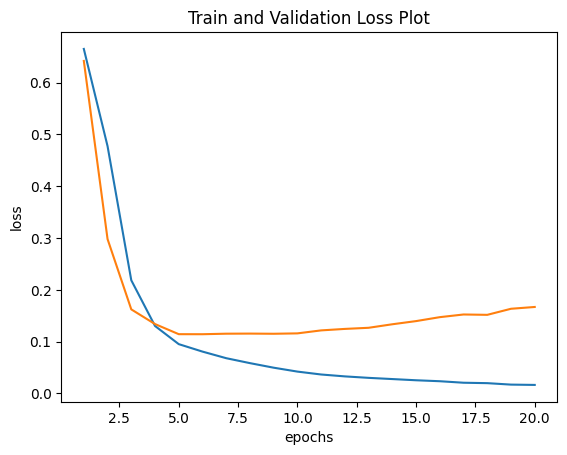

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), history.history['loss'])
plt.plot(range(1,epochs+1), history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

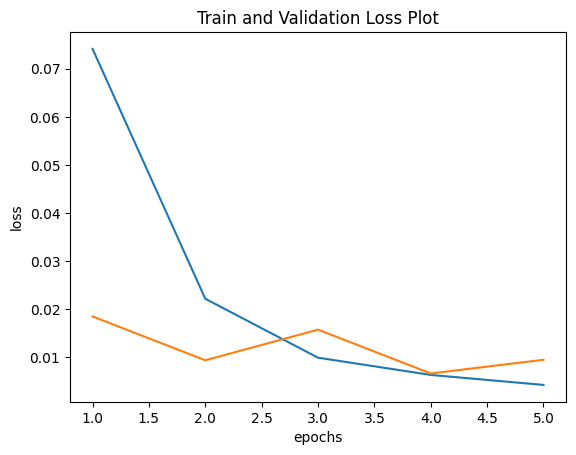

In [ ]:
plt.plot(range(1,epochs_xl+1), history_xl.history['loss'])
plt.plot(range(1,epochs_xl+1), history_xl.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [ ]:
predict_headline = str(input())
predict_headline = tokenize(predict_headline)
test_predict_headline = xlnetmodel.predict(predict_headline)